In [1]:
# -*- encoding: utf-8 -*-
import IPython.display as display
import os
import numpy as np
import math
import torch
from torch.utils.data import Dataset
from torch import nn
import hickle as hkl
from models import Generator
import hickle as hkl
import matplotlib
import matplotlib.pyplot as plt
import pytorch_ssim
from torch.autograd import Variable
from skimage.metrics import peak_signal_noise_ratio, structural_similarity

torch.cuda.set_device(0)
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "./result_wgan-gp/best_checkpoint_epoch0632.pth"
data_path = './data/K562/test_data_half.hkl'
class testDataset(Dataset):
    def __init__(self):
        lo, hi, distance_chrome = hkl.load(data_path)
        lo = lo.squeeze()
        hi = hi.squeeze()
        lo = np.expand_dims(lo,axis=1)
        hi = np.expand_dims(hi,axis=1)
        
        self.sample_list = []
        for i in range(len(lo)):
            lr = lo[i]
            hr = hi[i]
            dist = distance_chrome[i][0]
            chrom = distance_chrome[i][1]
            self.sample_list.append([lr, hr, dist, chrom])
        print("dataset loaded : " + str(len(lo)) + '*' + str(len(lo[0])) + '*' + str(len(lo[0][0])) + '*' + str(len(lo[0][0][0])))

    def __getitem__(self, i):
        (lr_img, hr_img, distance, chromosome) = self.sample_list[i]
        return lr_img, hr_img, distance, chromosome

    def __len__(self):
        return len(self.sample_list)
    
def psnr(img1, img2):
    img1 = np.float64(img1)
    img2 = np.float64(img2)
    mse = np.mean( (img1 - img2) ** 2 )
    if mse == 0:
        return 100
    PIXEL_MAX = 255.0
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))

def ssim(img1,img2):
    img1 = torch.from_numpy(np.rollaxis(img1, 2)).float().unsqueeze(0)/255.0
    img2 = torch.from_numpy(np.rollaxis(img2, 2)).float().unsqueeze(0)/255.0   
    img1 = Variable( img1,  requires_grad=False)    # torch.Size([256, 256, 3])
    img2 = Variable( img2, requires_grad = False)
    ssim_value = pytorch_ssim.ssim(img1, img2).item()
    return ssim_value

In [2]:
checkpoint = torch.load(model_path)
test_dataset = testDataset()
test_loader = torch.utils.data.DataLoader(test_dataset,
                                               batch_size=1,
                                               shuffle=False,
                                               num_workers=1,
                                               pin_memory=True)
generator = Generator(kernel_size=3,n_channels=64,n_blocks=5)
generator = generator.to(device)
generator.load_state_dict(checkpoint['generator'])
generator = generator.eval()
mse_loss_criterion = nn.MSELoss()
mse_loss_criterion = mse_loss_criterion.to(device)

dataset loaded : 2997*1*40*40


In [3]:
Y_mse = []
MSE_0 = []
MSE_40 = []
MSE_80 = []
MSE_120 = []
MSE_160 = []
Y_psnr = []
PSNR_0 = []
PSNR_40 = []
PSNR_80 = []
PSNR_120 = []
PSNR_160 = []
Y_ssim = []
SSIM_0 = []
SSIM_40 = []
SSIM_80 = []
SSIM_120 = []
SSIM_160 = []
for i, (lr_img, hr_img, distance, chrom) in enumerate(test_loader):
    display.clear_output(wait=True)
    print("***开始测试***")
    print("正在处理 ： " + str(i+1) + "/" + str(len(test_dataset))) # 3173/5
    print("MSE_AVG = " + str(np.mean(Y_mse))  + "  PSNR_AVG = " + str(np.mean(Y_psnr))+ "  SSIM_AVG = " + str(np.mean(Y_ssim)))
    print("MSE_0   = " + str(np.mean(MSE_0))  + "  PSNR_0   = " + str(np.mean(PSNR_0))+ "  SSIM_0   = " + str(np.mean(SSIM_0)))
    print("MSE_40  = " + str(np.mean(MSE_40)) + "  PSNR_40  = " + str(np.mean(PSNR_40))+ "  SSIM_40  = " + str(np.mean(SSIM_40)))
    print("MSE_80  = " + str(np.mean(MSE_80)) + "  PSNR_80  = " + str(np.mean(PSNR_80))+ "  SSIM_80  = " + str(np.mean(SSIM_80)))
    print("MSE_120 = " + str(np.mean(MSE_120))+ "  PSNR_120 = " + str(np.mean(PSNR_120))+ "  SSIM_120 = " + str(np.mean(SSIM_120)))
    print("MSE_160 = " + str(np.mean(MSE_160))+ "  PSNR_160 = " + str(np.mean(PSNR_160))+ "  SSIM_160 = " + str(np.mean(SSIM_160)))
    #img = lr_img.type(torch.FloatTensor).squeeze()
    lr_img = lr_img.type(torch.FloatTensor).to(device)
    hr_img_gpu = hr_img.type(torch.FloatTensor).to(device)
    with torch.no_grad():
        sr_img = generator(lr_img.detach())
    mse = mse_loss_criterion(sr_img , hr_img_gpu).to('cpu')
    sr_img = sr_img.squeeze().to("cpu").numpy()
    hr_img = hr_img.squeeze().numpy()
#     psnr = psnr(sr_img,hr_img)
#     ssim = ssim(sr_img,hr_img)
    psnr = peak_signal_noise_ratio(hr_img, sr_img)
    ssim = structural_similarity(hr_img, sr_img)
    
    Y_mse.append(mse)
    Y_psnr.append(psnr)
    Y_ssim.append(ssim)
    if abs(distance) == 0:
        MSE_0.append(mse)
        PSNR_0.append(psnr)
        SSIM_0.append(ssim)
    elif abs(distance) == 40:
        MSE_40.append(mse)
        PSNR_40.append(psnr)
        SSIM_40.append(ssim)
    elif abs(distance) == 80:
        MSE_80.append(mse)
        PSNR_80.append(psnr)
        SSIM_80.append(ssim)
    elif abs(distance) == 120:
        MSE_120.append(mse)
        PSNR_120.append(psnr)
        SSIM_120.append(ssim)
    elif abs(distance) == 160:
        MSE_160.append(mse)
        PSNR_160.append(psnr)
        SSIM_160.append(ssim)
print("***测试结束***")

***开始测试***
正在处理 ： 2997/2997
MSE_AVG = 0.035261165  PSNR_AVG = 21.587009401224748  SSIM_AVG = 0.2747187192783682
MSE_0   = 0.013932847  PSNR_0   = 25.352449458798503  SSIM_0   = 0.5331836636993224
MSE_40  = 0.023784742  PSNR_40  = 22.985769232512745  SSIM_40  = 0.306370198881099
MSE_80  = 0.0400623  PSNR_80  = 20.436165117416206  SSIM_80  = 0.19878756213483492
MSE_120 = 0.05082128  PSNR_120 = 19.256716240834283  SSIM_120 = 0.1489067427212247
MSE_160 = 0.054319452  PSNR_160 = 18.948233488450153  SSIM_160 = 0.1340287910676012
***测试结束***


MSE_AVG = 0.035252288
MSE_0   = 0.013924792
MSE_40  = 0.023784742
MSE_80  = 0.0400623
MSE_120 = 0.05082128
MSE_160 = 0.054319452


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  


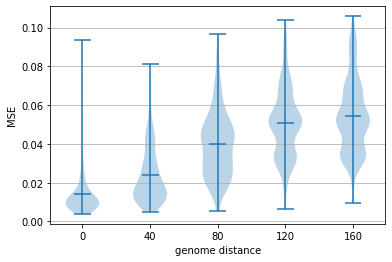

In [4]:
data = [MSE_0, MSE_40, MSE_80, MSE_120, MSE_160]
plt.violinplot(data,showmeans=True)
plt.xlabel('genome distance')
plt.ylabel('MSE')
plt.grid(axis='y')
plt.gca().set_xticklabels(['','0','40','80','120','160'])
print("MSE_AVG = " + str(np.mean(Y_mse)))
print("MSE_0   = " + str(np.mean(MSE_0)))
print("MSE_40  = " + str(np.mean(MSE_40)))
print("MSE_80  = " + str(np.mean(MSE_80)))
print("MSE_120 = " + str(np.mean(MSE_120)))
print("MSE_160 = " + str(np.mean(MSE_160)))